<a href="https://colab.research.google.com/github/MorganChidley/Final-Year-Project/blob/main/ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Datasets


**Decreasing 1st dataset from 50,000 URLs to 4000**

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('phishing_site_urls.csv')

# Rename the 'Label' column to 'ClassLabel'
df = df.rename(columns={'Label': 'ClassLabel'})

# Map labels: 'bad' to 0 and 'good' to 1
df['ClassLabel'] = df['ClassLabel'].map({'bad': 0, 'good': 1})

# Separate and sample
good_urls = df[df['ClassLabel'] == 1]
bad_urls = df[df['ClassLabel'] == 0]
sampled_good = good_urls.sample(n=2000, random_state=42)
sampled_bad = bad_urls.sample(n=2000, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([sampled_good, sampled_bad])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced dataset
balanced_df.to_csv('dataset2.csv', index=False)

**Merging Datasets**

In [ ]:
df1 = pd.read_csv('dataset1.csv')
df2 = pd.read_csv('dataset2.csv')

merged_df = pd.concat([df1, df2], ignore_index=True)

# View the first few rows
merged_df.head()

#Save it to a new CSV file
merged_df.to_csv('final_dataset.csv', index=False)

print(df1.shape)
print(df2.shape)
print(merged_df.shape)


(905, 2)
(4000, 2)
(4905, 2)


# EDA/Feature Engineering

**Importing final dataset**

In [ ]:
import pandas as pd
import re
from urllib.parse import urlparse
from collections import Counter
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from IPython.display import display

# Load the dataset
data = pd.read_csv('final_dataset.csv')

# Display the first few rows of the data
data.head()

,URL,ClassLabel
0,https://keraekken-loagginnusa.godaddysites.com/,0
1,https://metamsk01lgiix.godaddysites.com/,0
2,http://myglobaltech.in/,0
3,http://djtool-for-spotify.com/,0
4,https://scearmcoommunnlty.com/invent/freind/get,0


**Displaying number of Rows and Columns**

In [ ]:
data = pd.read_csv('final_dataset.csv')

# Get the shape of the data (number of rows and columns)
data.shape

(4905, 2)

**Checking dataset for missing values**

In [ ]:
data = pd.read_csv('final_dataset.csv')

# Check for missing values
data.isnull().sum()

,0
URL,0
ClassLabel,0


**Removing duplicates from dataset**

In [ ]:
data = pd.read_csv('final_dataset.csv')

# Remove duplicate rows
data.drop_duplicates(inplace=True)

# Check the new shape of the dataset
data.shape

(4897, 2)

**Feature Extraction**

In [ ]:
data = pd.read_csv('final_dataset.csv')


# Feature Extraction

def url_length(url):
    """Returns the total length of the URL."""
    return len(url)

def domain_length(url):
    """Returns the length of the domain portion."""
    domain = urlparse(url).netloc
    return len(domain)

def count_subdomains(url):
    """Counts the number of subdomains in the domain."""
    parsed_url = urlparse(url).netloc
    parsed_url = parsed_url.split(':')[0]
    return parsed_url.count('.') - 1

def path_length(url):
    """Returns the length of the URL path."""
    return len(urlparse(url).path)

def path_slash_count(url):
    """Counts the number of slashes in the path."""
    path = urlparse(url).path
    return path.count('/')

def has_https(url):
    """Checks if the URL uses HTTPS."""
    return 1 if urlparse(url).scheme == "https" else 0

def has_ip_address(url):
    """Checks if the URL contains an IP address."""
    ip_pattern = r'\b(?:\d{1,3}\.){3}\d{1,3}\b'
    return 1 if re.search(ip_pattern, url) else 0

def domain_is_ip(url):
    """Checks if the domain is an IP address."""
    domain = urlparse(url).netloc
    return 1 if re.fullmatch(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', domain) else 0

def count_query_parameters(url):
    """Counts the number of query parameters."""
    query = urlparse(url).query
    return len(query.split("&")) if query else 0

def count_digits(url):
    """Counts the number of digits in the URL."""
    return sum(char.isdigit() for char in url)

def longest_digit_sequence(url):
    """Finds the longest sequence of digits in the URL."""
    sequences = re.findall(r'\d+', url)
    return max((len(seq) for seq in sequences), default=0)

def digit_letter_ratio(url):
    """Calculates the ratio of digits to letters."""
    digits = sum(c.isdigit() for c in url)
    letters = sum(c.isalpha() for c in url)
    return digits / letters if letters > 0 else 0

def url_entropy(url):
    """Calculates the Shannon entropy of the URL."""
    if not url:
        return 0
    counter = Counter(url)
    length = len(url)
    entropy = -sum((count / length) * math.log2(count / length) for count in counter.values())
    return entropy

def count_special_chars(url):
    """Counts specific special characters in the URL."""
    special_chars = ["-", "_", "%", "/", ".", "@"]
    return {char: url.count(char) for char in special_chars}

def has_at_symbol(url):
    """Checks if the URL contains an '@' symbol."""
    return 1 if "@" in url else 0

def has_double_slash(url):
    """Checks if there is a '//' in the path (after the domain)."""
    after_protocol = url.split('//', 1)[-1]
    return 1 if '//' in after_protocol else 0

def has_suspicious_words(url):
    """Checks for suspicious phishing-related keywords in the URL."""
    suspicious_words = [
        "login", "signin", "bank", "update", "free", "lucky", "bonus", "ebay",
        "verify", "secure", "webscr", "account", "paypal", "payment"
    ]
    url_lower = url.lower()
    return 1 if any(word in url_lower for word in suspicious_words) else 0


# Apply each feature function
data["url_length"] = data["URL"].apply(url_length)
data["domain_length"] = data["URL"].apply(domain_length)
data["subdomain_count"] = data["URL"].apply(count_subdomains)
data["path_length"] = data["URL"].apply(path_length)
data["path_slash_count"] = data["URL"].apply(path_slash_count)
data["https"] = data["URL"].apply(has_https)
data["has_ip_address"] = data["URL"].apply(has_ip_address)
data["domain_is_ip"] = data["URL"].apply(domain_is_ip)
data["query_parameters_count"] = data["URL"].apply(count_query_parameters)
data["digit_count"] = data["URL"].apply(count_digits)
data["longest_digit_sequence"] = data["URL"].apply(longest_digit_sequence)
data["digit_letter_ratio"] = data["URL"].apply(digit_letter_ratio)
data["url_entropy"] = data["URL"].apply(url_entropy)
data["has_at_symbol"] = data["URL"].apply(has_at_symbol)
data["has_double_slash"] = data["URL"].apply(has_double_slash)
data["has_suspicious_words"] = data["URL"].apply(has_suspicious_words)

# Extract counts of special characters and merge with main dataframe
special_chars_df = data["URL"].apply(count_special_chars).apply(pd.Series)
special_chars_df.columns = [f"char_{col}" for col in special_chars_df.columns]  # Prefix for clarity

# Concatenate new features
data = pd.concat([data, special_chars_df], axis=1)

# Remove duplicate columns if any
data = data.loc[:, ~data.columns.duplicated()]

#Save it to a new CSV file
data.to_csv('final_dataset_1.csv', index=False)

# Display first few rows to verify
data.head()

,URL,ClassLabel,url_length,domain_length,subdomain_count,path_length,path_slash_count,https,has_ip_address,domain_is_ip,...,url_entropy,has_at_symbol,has_double_slash,has_suspicious_words,char_-,char__,char_%,char_/,char_.,char_@
0,https://keraekken-loagginnusa.godaddysites.com/,0,47,38,1,1,1,1,0,0,...,4.250669,0,0,0,1,0,0,3,2,0
1,https://metamsk01lgiix.godaddysites.com/,0,40,31,1,1,1,1,0,0,...,4.196439,0,0,0,0,0,0,3,2,0
2,http://myglobaltech.in/,0,23,15,0,1,1,0,0,0,...,3.936180,0,0,0,0,0,0,3,1,0
3,http://djtool-for-spotify.com/,0,30,22,0,1,1,0,0,0,...,3.894740,0,0,0,2,0,0,3,1,0
4,https://scearmcoommunnlty.com/invent/freind/get,0,47,21,0,18,3,1,0,0,...,4.143127,0,0,0,0,0,0,5,1,0


**Deploying Correlation matrix**

In [ ]:
data = pd.read_csv("final_dataset_1.csv")

# Drop the 'ClassLabel' column
data = data.drop('ClassLabel', axis=1)

# Select numeric columns
numeric_data = data.select_dtypes(include=np.number)

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Display correlation matrix as a table
correlation_table = correlation_matrix.style.background_gradient(cmap='coolwarm')

correlation_table

,url_length,domain_length,subdomain_count,path_length,path_slash_count,https,has_ip_address,domain_is_ip,query_parameters_count,digit_count,longest_digit_sequence,digit_letter_ratio,url_entropy,has_at_symbol,has_double_slash,has_suspicious_words,char_-,char__,char_%,char_/,char_.,char_@
url_length,1.000000,-0.048483,-0.086425,0.567361,0.343466,-0.004343,-0.104487,-0.016230,0.586422,0.756987,0.365417,0.012893,0.662058,0.096134,0.023762,0.312231,0.427773,0.386063,0.546154,0.326812,0.503059,0.096134
domain_length,-0.048483,1.000000,0.877097,-0.399189,-0.217041,0.516653,0.177929,0.062689,-0.114745,0.033049,0.031240,0.223184,0.039022,-0.028645,-0.010680,-0.058792,-0.011827,-0.058351,-0.027447,0.191942,0.030710,-0.028645
subdomain_count,-0.086425,0.877097,1.000000,-0.415024,-0.230725,0.475911,0.428540,0.203685,-0.119378,0.047548,0.043149,0.431493,-0.039451,-0.033110,-0.011023,-0.080292,-0.065953,-0.038161,-0.027131,0.191829,0.095677,-0.033110
path_length,0.567361,-0.399189,-0.415024,1.000000,0.609425,-0.176858,-0.190404,-0.042553,0.044746,0.390754,0.330667,-0.101633,0.478620,0.053598,-0.015648,0.276010,0.472254,0.231337,0.014684,0.360523,0.360374,0.053598
path_slash_count,0.343466,-0.217041,-0.230725,0.609425,1.000000,-0.056984,-0.164223,-0.024334,0.017235,0.129712,0.155545,-0.105608,0.348561,0.053990,-0.014378,0.208969,0.207315,0.116137,-0.013283,0.827454,0.080565,0.053990
https,-0.004343,0.516653,0.475911,-0.176858,-0.056984,1.000000,-0.073746,-0.019804,-0.078391,-0.085083,-0.096271,-0.098693,0.048766,-0.015324,-0.007471,-0.054143,0.021440,0.053598,-0.012512,0.223047,-0.079542,-0.015324
has_ip_address,-0.104487,0.177929,0.428540,-0.190404,-0.164223,-0.073746,1.000000,0.268541,-0.061808,0.176239,0.144467,0.777047,-0.191202,-0.019787,-0.006041,-0.073652,-0.106236,-0.067834,-0.018499,-0.039379,0.220485,-0.019787
domain_is_ip,-0.016230,0.062689,0.203685,-0.042553,-0.024334,-0.019804,0.268541,1.000000,-0.018428,0.040848,0.017057,0.104643,-0.005353,-0.005314,-0.001622,-0.024804,-0.028647,-0.006063,-0.004968,0.037179,0.104959,-0.005314
query_parameters_count,0.586422,-0.114745,-0.119378,0.044746,0.017235,-0.078391,-0.061808,-0.018428,1.000000,0.415022,0.180998,-0.005218,0.420300,0.136022,0.029335,0.180385,0.055672,0.217803,0.393999,0.032489,0.360561,0.136022
digit_count,0.756987,0.033049,0.047548,0.390754,0.129712,-0.085083,0.176239,0.040848,0.415022,1.000000,0.614723,0.383430,0.445969,0.031458,-0.005775,0.208694,0.207566,0.196325,0.445752,0.123381,0.494905,0.031458


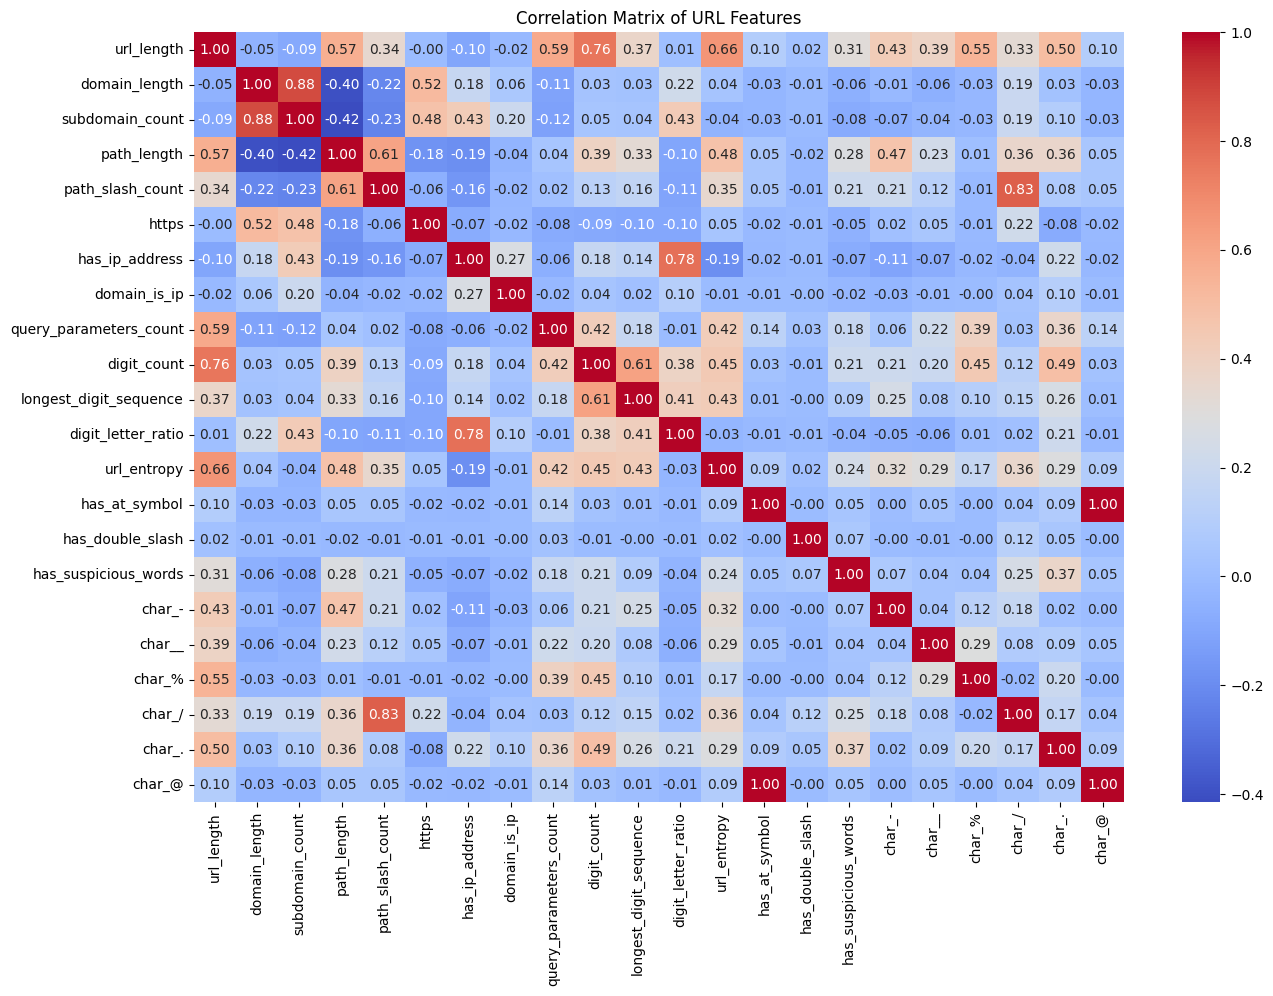

In [ ]:
# Create heatmap
plt.figure(figsize=(15, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of URL Features')
plt.show()

**Deploying Mutual Information**

In [ ]:
data = pd.read_csv("final_dataset_1.csv")

X = data.drop(['ClassLabel', "URL"], axis=1)
y = data['ClassLabel']

# Mutual Information
mutual_info = mutual_info_classif(X, y)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mutual_info})
feature_scores = feature_scores.sort_values(by=['Mutual_Information'], ascending=False)

# Display mutual information scores in a table
display(feature_scores)

,Feature,Mutual_Information
1,domain_length,0.094524
3,path_length,0.073870
11,digit_letter_ratio,0.073433
9,digit_count,0.061173
15,has_suspicious_words,0.059937
20,char_.,0.059408
12,url_entropy,0.050091
2,subdomain_count,0.044249
6,has_ip_address,0.037289
19,char_/,0.035296


# Baseline Model Development

**Training Models with basic parameters**

In [ ]:
from pickle import TRUE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import display

# Load Dataset
data = pd.read_csv("final_dataset_1.csv")

# Feature Selection
features = ["url_length", "domain_length", "subdomain_count", "path_length", "path_slash_count", "https", "has_ip_address", "query_parameters_count",
            "digit_count", "longest_digit_sequence", "digit_letter_ratio", "url_entropy", "has_suspicious_words", "char_-", "char__",
            "char_/", "char_.", "char_@"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train and evaluate multiple models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models using cross-validation
kfold_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')
    kfold_results[model_name] = {
        "Model": model_name,
        "Mean Accuracy": np.mean(scores),
        "Standard Deviation": np.std(scores)
    }

# Store results in a list of dictionaries
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
# Display the DataFrame

   # Extract precision, recall, and F1-score for each class
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    precision = report_dict['weighted avg']['precision']
    recall = report_dict['weighted avg']['recall']
    f1_score = report_dict['weighted avg']['f1-score']

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': conf_matrix,
    })

# Create a Pandas DataFrame from the results
results_df = pd.DataFrame(results)
kfold_results_df = pd.DataFrame(kfold_results.values())

# Reorder columns
kfold_results_df = kfold_results_df[['Model', 'Mean Accuracy', 'Standard Deviation']]

# Display the DataFrame
display(results_df)
display(kfold_results_df)

<ipython-input-48-9fe62f21091b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Confusion Matrix
0,Logistic Regression,0.743119,0.767713,0.743119,0.744603,0.853040,"[[388, 185], [67, 341]]"
1,Decision Tree,0.773700,0.775036,0.773700,0.774209,0.771054,"[[455, 118], [104, 304]]"
2,Random Forest,0.837920,0.839510,0.837920,0.838398,0.917216,"[[484, 89], [70, 338]]"
3,SVM,0.803262,0.830818,0.803262,0.804320,0.895472,"[[415, 158], [35, 373]]"
4,MLP,0.839959,0.850985,0.839959,0.841079,0.928139,"[[459, 114], [43, 365]]"


,Model,Mean Accuracy,Standard Deviation
0,Logistic Regression,0.744343,0.004247
1,Decision Tree,0.783282,0.015879
2,Random Forest,0.827931,0.007133
3,SVM,0.801223,0.002497
4,MLP,0.837309,0.011252


# Hyperparameter Tuning

**Hyperparamter Tuning using grid search**

In [ ]:
from pickle import TRUE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import display

# Load Dataset
data = pd.read_csv("final_dataset_1.csv")

# Feature Selection
features = ["url_length", "domain_length", "subdomain_count", "path_length", "path_slash_count", "https", "has_ip_address", "query_parameters_count",
            "digit_count", "longest_digit_sequence", "digit_letter_ratio", "url_entropy", "has_suspicious_words", "char_-", "char__",
            "char_/", "char_.", "char_@"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models and parameter grids for tuning
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}

# Define models and parameter grids for tuning
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "MLP": {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01]
    }
}


# Perform hyperparameter tuning and evaluate models
cv_results = {}
for model_name, param_grid in param_grids.items():
    print(f"Tuning {model_name}...")
    model = models[model_name]  # Get model instance from dictionary
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_scaled, y)

    # Store results
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    cv_results[model_name] = {
        "Best Parameters": best_params,
        "Best Accuracy": best_score
    }

# Print and log results
log_data = []
for model, result in cv_results.items():
    print(f"{model}: Best Accuracy = {result['Best Accuracy']:.4f}, Best Parameters = {result['Best Parameters']}")
    log_data.append([model, result['Best Accuracy'], result['Best Parameters']])

# Save tuning results to CSV
df_log = pd.DataFrame(log_data, columns=['Model', 'Best Accuracy', 'Best Parameters'])
df_log.to_csv("Model_Tuning_Results.csv", index=False)

print("Hyperparameter tuning complete! Results saved in Model_Tuning_Results.csv")


Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


<ipython-input-50-08445df43a51>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


Tuning Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Tuning Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Tuning SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Tuning MLP...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Logistic Regression: Best Accuracy = 0.7454, Best Parameters = {'C': 10, 'solver': 'lbfgs'}
Decision Tree: Best Accuracy = 0.7953, Best Parameters = {'max_depth': 10, 'min_samples_split': 2}
Random Forest: Best Accuracy = 0.8373, Best Parameters = {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}
SVM: Best Accuracy = 0.8214, Best Parameters = {'C': 10, 'kernel': 'rbf'}
MLP: Best Accuracy = 0.8367, Best Parameters = {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Hyperparameter tuning complete! Results saved in Model_Tuning_Results.csv


**Model Optimisation, Validation Curves, Over/Under fitting**

<ipython-input-62-6f7270e0edf6>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


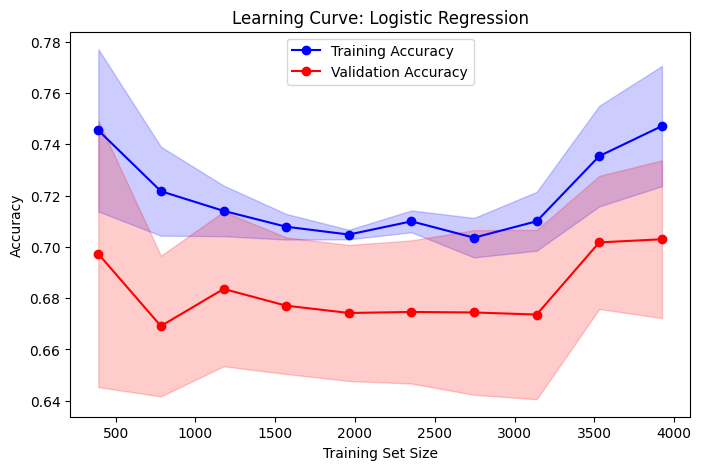

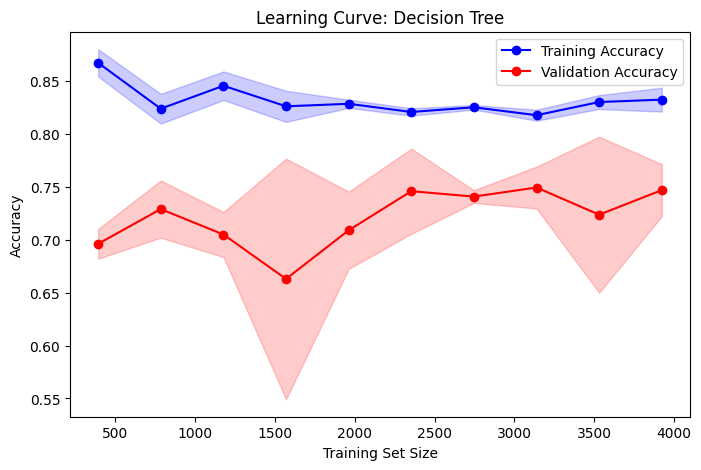

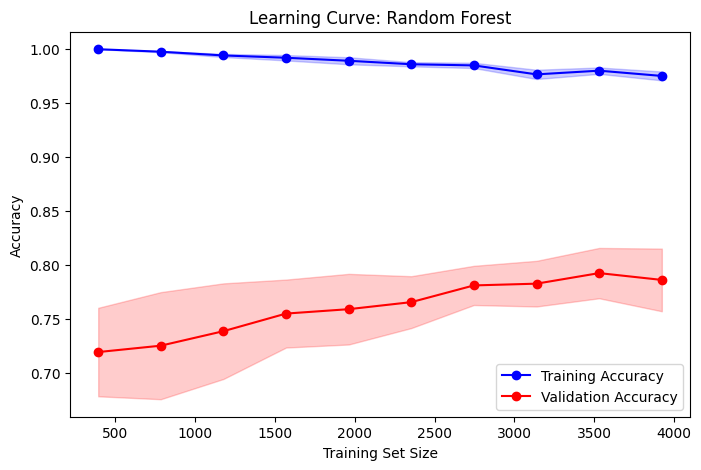

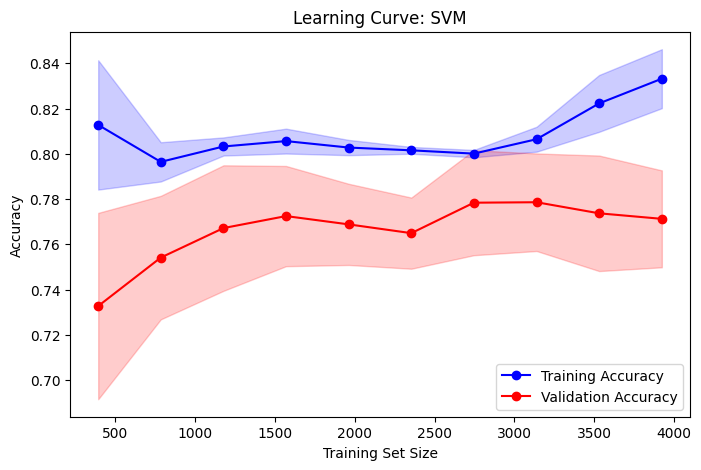

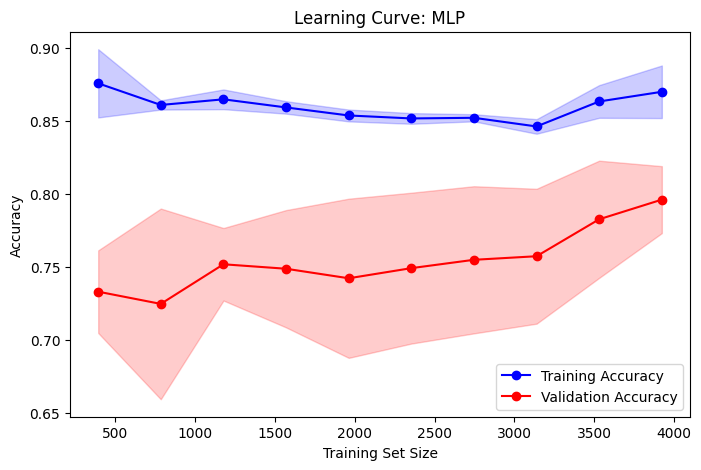

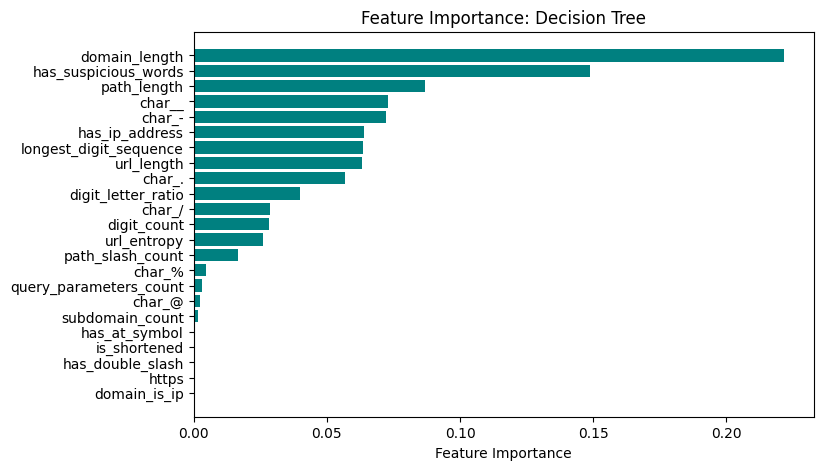

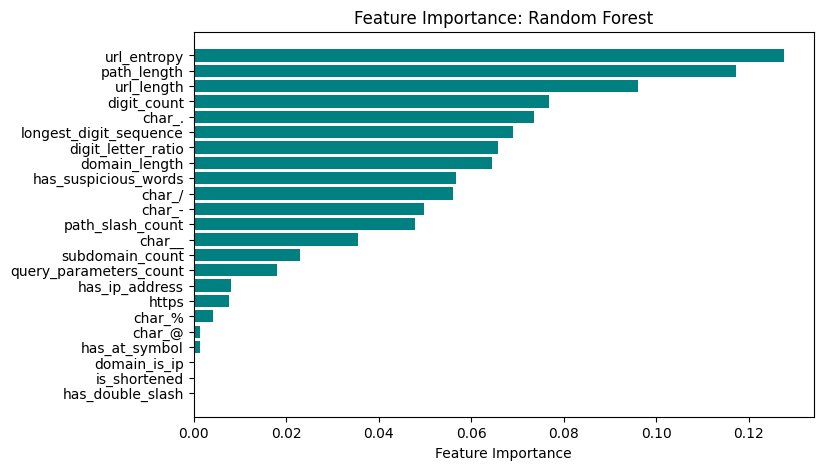

Analysis complete! Check the plots for insights.


In [ ]:
from pickle import TRUE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import display

# Load Dataset
data = pd.read_csv("final_dataset_1.csv")

# Feature Selection
features = ["url_length", "domain_length", "subdomain_count", "path_length", "path_slash_count", "https", "has_ip_address", "query_parameters_count",
            "digit_count", "longest_digit_sequence", "digit_letter_ratio", "url_entropy", "has_suspicious_words", "char_-", "char__",
            "char_/", "char_.", "char_@"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models and parameter grids for tuning
models = {
       "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2), # Updated parameters
       "SVM": SVC(C=10, kernel='rbf', probability=True), # Updated parameters and added probability=True
       "MLP": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.01, solver='adam', max_iter=500) # Updated parameters
   }
# Function to plot learning curves
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Accuracy')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='red', alpha=0.2)

    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve: {model_name}")
    plt.legend()
    plt.show()

# Plot learning curves for all models
for model_name, model in models.items():
    plot_learning_curve(model, X_scaled, y, model_name)

# Feature Importance (for Decision Tree & Random Forest)
def plot_feature_importance(model, model_name):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 5))
    plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx], color='teal')
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importance: {model_name}")
    plt.show()

# Train tree-based models and plot feature importance
tree_models = ["Random Forest"]
for model_name in tree_models:
    model = models[model_name].fit(X_scaled, y)
    plot_feature_importance(model, model_name)

print("Analysis complete! Check the plots for insights.")



**Validation for performance esitmates**

In [ ]:
from pickle import TRUE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from IPython.display import display
from sklearn.pipeline import Pipeline

# Load Dataset
data = pd.read_csv("final_dataset_1.csv")

# Feature Selection
features = ["url_length", "domain_length", "subdomain_count", "path_length", "path_slash_count", "https", "has_ip_address", "query_parameters_count",
            "digit_count", "longest_digit_sequence", "digit_letter_ratio", "url_entropy", "has_suspicious_words", "char_-", "char__",
            "char_/", "char_.", "char_@"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define models and parameter grids for tuning
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10),
    "SVM": SVC(C=10, kernel='rbf'),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,50), activation='tanh', solver='adam', alpha=0.001, max_iter=500)
}

# Define models with pipelines
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(C=10, kernel='rbf'))
    ]),
    "MLP": Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', alpha=0.001, max_iter=500))
    ])
}

# Nested Cross-Validation Setup
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Perform Nested CV Evaluation
cv_results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name} using Nested Cross-Validation...")
    scores = cross_val_score(model, X_train, y_train, cv=outer_cv, scoring='accuracy', n_jobs=-1)
    mean_score, std_score = np.mean(scores), np.std(scores)

    # Store results
    cv_results[model_name] = {
        "Mean Accuracy": mean_score,
        "Std Deviation": std_score
    }

# Print results
for model, result in cv_results.items():
    print(f"{model}: Mean Accuracy = {result['Mean Accuracy']:.4f}, Std Dev = {result['Std Deviation']:.4f}")

# Evaluate final models on the validation set
val_results = {}
for model_name, model in models.items():
       model.fit(X_train, y_train)
       val_accuracy = model.score(X_val, y_val)  # Use X_val and y_val here
       val_results[model_name] = val_accuracy


# Print validation results
print("\nFinal Validation Set Performance:")
for model, acc in val_results.items():
    print(f"{model}: Validation Accuracy = {acc:.4f}")

print("Nested Cross-Validation and Validation Set Evaluation Complete!")




<ipython-input-63-119f6ea2bed3>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


Evaluating Logistic Regression using Nested Cross-Validation...
Evaluating Decision Tree using Nested Cross-Validation...
Evaluating Random Forest using Nested Cross-Validation...
Evaluating SVM using Nested Cross-Validation...
Evaluating MLP using Nested Cross-Validation...
Logistic Regression: Mean Accuracy = 0.7426, Std Dev = 0.0130
Decision Tree: Mean Accuracy = 0.7856, Std Dev = 0.0142
Random Forest: Mean Accuracy = 0.8222, Std Dev = 0.0114
SVM: Mean Accuracy = 0.8082, Std Dev = 0.0070
MLP: Mean Accuracy = 0.8270, Std Dev = 0.0127

Final Validation Set Performance:
Logistic Regression: Validation Accuracy = 0.7376
Decision Tree: Validation Accuracy = 0.7834
Random Forest: Validation Accuracy = 0.8306
SVM: Validation Accuracy = 0.8064
MLP: Validation Accuracy = 0.8268
Nested Cross-Validation and Validation Set Evaluation Complete!


# Advanced Modelling & Ensemble Techniques

**Implementing Ensemble methods**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline

# Load Dataset
data = pd.read_csv("final_dataset_1.csv")

# Feature Selection
features = ["url_length", "domain_length", "subdomain_count", "path_length", "path_slash_count", "https", "has_ip_address", "query_parameters_count",
            "digit_count", "longest_digit_sequence", "digit_letter_ratio", "url_entropy", "has_suspicious_words", "char_-", "char__",
            "char_/", "char_.", "char_@"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5)),
    ('svm', SVC(C=1, kernel='rbf', probability=True)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.001, max_iter=500))
]

# Meta-model (Logistic Regression) for stacking
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Boosting models
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6)

# Train and evaluate ensemble models
ensemble_models = {
    "Stacking Classifier": stacking_model,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model
}

ensemble_results = {}
for model_name, model in ensemble_models.items():
    model.fit(X_train, y_train)
    val_accuracy = model.score(X_val, y_val)
    ensemble_results[model_name] = val_accuracy

# Print validation results
print("\nEnsemble Model Performance on Validation Set:")
for model, acc in ensemble_results.items():
    print(f"{model}: Validation Accuracy = {acc:.4f}")

print("Ensemble Learning Implementation Complete!")


<ipython-input-64-7ebcf69bed6c>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1125, number of negative: 1386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 2511, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448029 -> initscore=-0.208639
[LightGBM] [Info] Start training from score -0.208639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:51:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Cross-validation to benchmark the performance of ensemble models against individual models**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline

# Load Dataset
data = pd.read_csv("final_dataset_1.csv")

# Feature Selection
features = ["url_length", "domain_length", "subdomain_count", "path_length", "path_slash_count", "https", "has_ip_address", "query_parameters_count",
            "digit_count", "longest_digit_sequence", "digit_letter_ratio", "url_entropy", "has_suspicious_words", "char_-", "char__",
            "char_/", "char_.", "char_@"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define individual models
individual_models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2),  # Updated parameters
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(C=10, kernel='rbf', probability=True))  # Updated parameters
    ]),
    "MLP": Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.01, solver='adam', max_iter=500))  # Updated parameters
    ])
}

# Define ensemble models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2)),  # Updated parameters
    ('svm', SVC(C=10, kernel='rbf', probability=True)),  # Updated parameters
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.01, solver='adam', max_iter=500))  # Updated parameters
]
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6)

ensemble_models = {
    "Stacking Classifier": stacking_model,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate individual models
cv_results = {}
for model_name, model in {**individual_models, **ensemble_models}.items():
    print(f"Evaluating {model_name} using Cross-Validation...")
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    mean_score, std_score = np.mean(scores), np.std(scores)

    # Store results
    cv_results[model_name] = {
        "Mean Accuracy": mean_score,
        "Std Deviation": std_score
    }

# Print results
print("\nCross-Validation Performance Comparison:")
for model, result in cv_results.items():
    print(f"{model}: Mean Accuracy = {result['Mean Accuracy']:.4f}, Std Dev = {result['Std Deviation']:.4f}")

print("Cross-Validation Benchmarking Complete!")





<ipython-input-65-1b09738e7204>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


Evaluating Logistic Regression using Cross-Validation...
Evaluating Decision Tree using Cross-Validation...
Evaluating Random Forest using Cross-Validation...
Evaluating SVM using Cross-Validation...
Evaluating MLP using Cross-Validation...
Evaluating Stacking Classifier using Cross-Validation...
Evaluating XGBoost using Cross-Validation...
Evaluating LightGBM using Cross-Validation...

Cross-Validation Performance Comparison:
Logistic Regression: Mean Accuracy = 0.7448, Std Dev = 0.0153
Decision Tree: Mean Accuracy = 0.7939, Std Dev = 0.0115
Random Forest: Mean Accuracy = 0.8343, Std Dev = 0.0077
SVM: Mean Accuracy = 0.8159, Std Dev = 0.0072
MLP: Mean Accuracy = 0.8351, Std Dev = 0.0068
Stacking Classifier: Mean Accuracy = 0.8351, Std Dev = 0.0060
XGBoost: Mean Accuracy = 0.8334, Std Dev = 0.0097
LightGBM: Mean Accuracy = 0.8353, Std Dev = 0.0088
Cross-Validation Benchmarking Complete!


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load Dataset
data = pd.read_csv("final_dataset_1.csv")

# Feature Selection
features = ["url_length", "domain_length", "subdomain_count", "path_length", "path_slash_count", "https", "has_ip_address", "query_parameters_count",
            "digit_count", "longest_digit_sequence", "digit_letter_ratio", "url_entropy", "has_suspicious_words", "char_-", "char__",
            "char_/", "char_.", "char_@"]
X = data[features]
y = data['ClassLabel']  # Target variable

# Handle missing values (fill with median)
X.fillna(X.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define individual models
individual_models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2),  # Updated parameters
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(C=10, kernel='rbf', probability=True))  # Updated parameters
    ]),
    "MLP": Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.01, solver='adam', max_iter=500))  # Updated parameters
    ])
}

# Define ensemble models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2)),  # Updated parameters
    ('svm', SVC(C=10, kernel='rbf', probability=True)),  # Updated parameters
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.01, solver='adam', max_iter=500))  # Updated parameters
]
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6)

ensemble_models = {
    "Stacking Classifier": stacking_model,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model
}


# =====================================================================
# ADDITIONAL EVALUATION: Precision, Recall, F1 on Validation Set
# =====================================================================

# Pick the best model to evaluate further - let's use MLP from individual_models
best_model_name = "Stacking Classifier"
best_model = individual_models[best_model_name]

# Train on training set
print(f"\nTraining {best_model_name} on training data...")
best_model.fit(X_train, y_train)

# Predict on validation set
y_pred = best_model.predict(X_val)

# Evaluate metrics
print(f"\n=== Evaluation on Validation Set using {best_model_name} ===")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report (Precision, Recall, F1-score):")
print(classification_report(y_val, y_pred))

# Accuracy for comparison
accuracy = accuracy_score(y_val, y_pred)
print(f"\nAccuracy on Validation Set: {accuracy:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'merged_dataset.csv'

In [ ]:
# Retrain on all data (optional)
final_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
final_model.fit(X_scaled, y)

# Save model and scaler
import joblib
joblib.dump(final_model, 'final_random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']